In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import ast
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Read Data

In [3]:
IMAGE_LOC = '/nvme/UCIAccData/'

In [4]:
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0]

In [5]:
activity_list

['/nvme/UCIAccData/Descend_stairs',
 '/nvme/UCIAccData/Use_telephone',
 '/nvme/UCIAccData/Standup_chair',
 '/nvme/UCIAccData/Standup_chair_MODEL',
 '/nvme/UCIAccData/Pour_water',
 '/nvme/UCIAccData/Comb_hair',
 '/nvme/UCIAccData/Walk_MODEL',
 '/nvme/UCIAccData/Pour_water_MODEL',
 '/nvme/UCIAccData/Sitdown_chair',
 '/nvme/UCIAccData/Eat_meat',
 '/nvme/UCIAccData/Climb_stairs',
 '/nvme/UCIAccData/Climb_stairs_MODEL',
 '/nvme/UCIAccData/Eat_soup',
 '/nvme/UCIAccData/Liedown_bed',
 '/nvme/UCIAccData/Brush_teeth',
 '/nvme/UCIAccData/Drink_glass',
 '/nvme/UCIAccData/Getup_bed_MODEL',
 '/nvme/UCIAccData/Drink_glass_MODEL',
 '/nvme/UCIAccData/Getup_bed',
 '/nvme/UCIAccData/Sitdown_chair_MODEL']

In [6]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

def get_position_velocity(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of displacement and speed time-series
    '''
    
    data_pos_vel = {}
    
    delta_time = 1 #time-step
    
    for k in data:
        data_pos_vel[k] = []
        
        for acc in data[k]:
            #x = x_0 + vt #constant velocity
            #v = u + at #constant acceleration
            #x = x_0 + ut + 1/2 at^2 #constant acceleration

            #discrete time - assume acceleration constant from step {t-1} to {t}
            #v_{t} = v_{t-1} + a_{t-1} t 
            #x_{t} = x_{t-1} + v_{t-1} t + 1/2 a_{t-1} t^2

            #set time t = 1 (unit). variable called delta_time
    
            #need to initialize p = (x,y,z), v = (vx, vy, vz)
            #assume initial position, velocity = 0
            
            pos, vel = np.zeros_like(acc), np.zeros_like(acc)
            
            for t in range(1, acc.shape[0]):
                vel[t] = vel[t-1] + acc[t-1] * delta_time
                
                pos[t] = pos[t-1] + vel[t-1]*delta_time + (1./2)*acc[t-1]*(delta_time**2)
                
                
            pos = np.sqrt((pos**2).sum(axis=1))
            vel = np.sqrt((vel**2).sum(axis=1))
            
            data_pos_vel[k].append((pos, vel))
            
    return data_pos_vel

In [7]:
data = read_data(activity_list)

In [8]:
data_ts = get_acceleration_timeseries(data)

In [9]:
data_pos_vel = get_position_velocity(data)

# Time-series plots

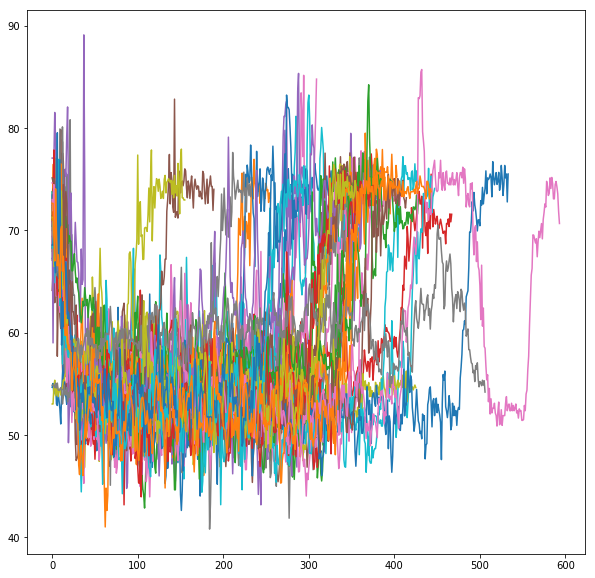

In [10]:
plt.figure(figsize=(10,10))
for elem in data_ts['Descend_stairs']:
    plt.plot(elem)

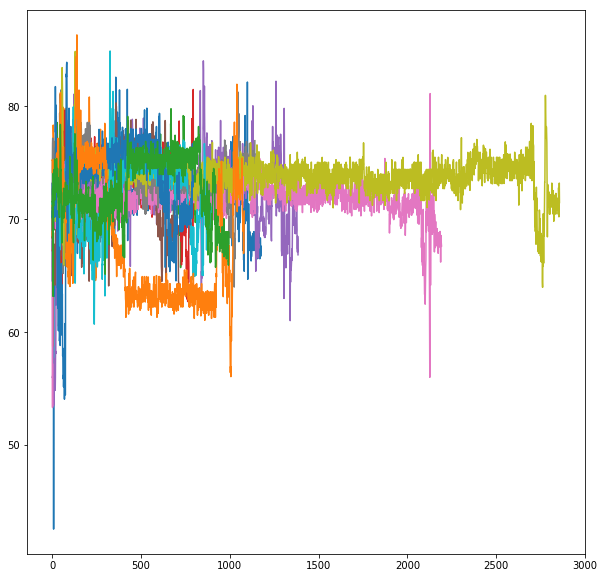

In [11]:
plt.figure(figsize=(10,10))
for elem in data_ts['Use_telephone']:
    plt.plot(elem)

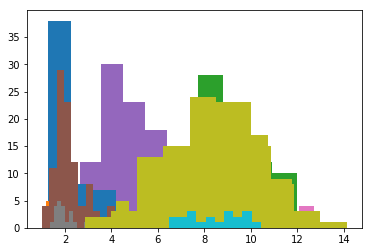

In [12]:
for k in data_ts:
    vols = []
    for val in data_ts[k]:
        vols.append(np.std(val))
        
    plt.hist(vols)

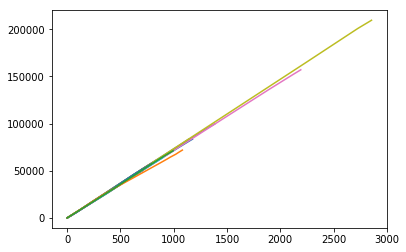

In [13]:
for elem in data_pos_vel['Use_telephone']:
    plt.plot(elem[1])
#for elem in data_pos_vel['Drink_glass']:
#    plt.plot(elem[1])    

In [14]:
#why no negative acc components?
for k in data:
    for elem in data[k]:
        if np.sum(elem < 0) > 0:
            print("Hello")

### Featurizer 1 - statistical properties of acceleration time-series

In [15]:
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    features = {'mean_over_median': mean/median, #dimensionless            
                'std_over_median': std/median, #dimensionless            
                'length': length,
                'kurtosis': kurtosis, #already dimensionless by definition
               }
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    return features

{'mean_over_median': 0.9933543400987399, 'std_over_median': 0.10735163170131132, 'length': 2472, 'kurtosis': 0.49592832932332964, 'binfrac_0': 0.0, 'binfrac_1': 0.0, 'binfrac_2': 0.0, 'binfrac_3': 0.00040551500405515005, 'binfrac_4': 0.009732360097323601, 'binfrac_5': 0.13746958637469586, 'binfrac_6': 0.4464720194647202, 'binfrac_7': 0.3742903487429035, 'binfrac_8': 0.031630170316301706}


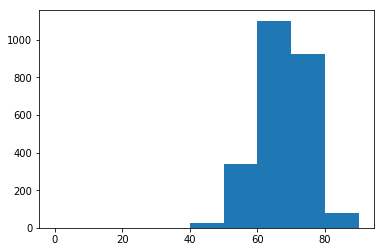

In [16]:
x = featurize_stats(data_ts['Brush_teeth'][0], np.arange(0,100,10))

print(x)

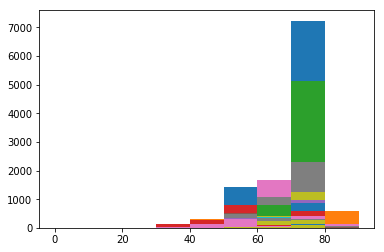

In [17]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_ts: #slow, should parallelize
    for elem in data_ts[k]:
        df.append(featurize_stats(elem, bins))
        labels.append(k)

In [18]:
df = pd.DataFrame(df)

In [19]:
df['label'] = labels

In [27]:
#dirty, sloppy model - no preprocessing, no train/test etc.
model = LogisticRegression()
model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

0.5051194539249146


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sanjay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [28]:
model = RandomForestClassifier()

model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

0.944254835039818


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [57]:
train_df, test_df = train_test_split(df, train_size=0.40)

/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [58]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.7863247863247863, test_acc = 0.5738636363636364


In [42]:
?RandomForestClassifier

### Featurizer 2 - scaled acceleration time-series

In [ ]:
data_ts.keys()

### Featurizer 3 - velocity vs position plots

In [ ]:
?plt.hist